## Lineage plotter
Notebook to plot lineage trees / timelines for PDX models.<br>
This was used primarily for data QC for our publication:<br>
https://www.biorxiv.org/content/10.1101/2023.01.06.521078v1

In [1]:
import pandas as pd
import numpy as np
#%matplotlib inline
%matplotlib Agg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from pathlib import Path

In [2]:
out_dir = Path("./examples/output")
#tracker_excel = "DummyTracker.xlsx"
tracker_excel = Path("./examples/ExampleTrackerData.xlsx")
tracker_sheet = "PDX_Tracker"

cohort_excel = Path("./examples/ExampleTrackerData.xlsx")
patient_sheet = "Patient_Data"
region_sheet = "Region_Data"


In [9]:
def load_tracker(remove_exclude = False):
    #global tracker_df
    tracker_df = pd.read_excel(tracker_excel,sheet_name=tracker_sheet)#, index_col=0)
    tracker_df["RegionID"] = tracker_df["DonorID"].astype(str) + "_" + tracker_df["Tumour"].astype(str) + "-" + tracker_df["Region"].astype(str)
    tracker_df = tracker_df.set_index("SiteID")

    tracker_df.loc[pd.isnull(tracker_df["Lineage"]),"Lineage"] = "A0"
    #remove any parent-less P>0 as incomplete
    tracker_df = tracker_df.loc[~((tracker_df["Passage"]>0) & (tracker_df["Parent"].isnull()))]

    if remove_exclude:
        tracker_df = tracker_df[~(tracker_df["ExcludeMouse"]==1.0)]

    # sort by passage so iterrows below calculates time linearly
    tracker_df = tracker_df.sort_values("Passage")
    
    tracker_df.loc[tracker_df["Passage"]==0,"StartDays"] = 0
    tracker_df.loc[tracker_df["Passage"]==0,"EndDays"] = tracker_df.loc[tracker_df["Passage"]==0,"DaysCalc"]

    # Add the parent's number of days to child start/end/detected days
    # this assumes df is sorted by passage so will start at P0 then P1 etc
    for ix, row in tracker_df.dropna(subset=["Parent"]).iterrows():
        tracker_df.loc[ix,"StartDays"] = tracker_df.loc[tracker_df.loc[ix,"Parent"],"EndDays"]
        tracker_df.loc[ix,"EndDays"] = tracker_df.loc[ix,"StartDays"] + tracker_df.loc[ix,"DaysCalc"]
        if pd.notnull(tracker_df.loc[ix,"FirstDetected"]):
            tracker_df.loc[ix,"FirstDetected"] = tracker_df.loc[ix,"FirstDetected"] + tracker_df.loc[ix,"StartDays"]
        if pd.notnull(tracker_df.loc[ix,"LastDetected"]):
            tracker_df.loc[ix,"LastDetected"] = tracker_df.loc[ix,"LastDetected"] + tracker_df.loc[ix,"StartDays"]
    return tracker_df

In [4]:
def load_meta():
    patient_data = pd.read_excel(cohort_excel,sheet_name=patient_sheet)
    patient_data = patient_data.set_index("DonorID")
    #display(patient_data)

    pdx_data = pd.read_excel(cohort_excel,sheet_name=region_sheet)
    pdx_data["RegionID"] = pdx_data["DonorID"] + "_" + pdx_data["Region"]
    use_cols = ["RegionID","IHC","CanonicalLineage"]
    pdx_data = pdx_data[use_cols].set_index("RegionID")
    #display(pdx_data)
    return patient_data, pdx_data

In [10]:
tracker_df = load_tracker(False)
patient_data, pdx_data = load_meta()
display(patient_data)
display(pdx_data)

,Histology,Histology2,Histology_Short
DonorID,,,
CRUK0949,Squamous cell carcinoma,NaN,LUSC


,IHC,CanonicalLineage
RegionID,,
CRUK0949_T1-R1,Good,A0
CRUK0949_T1-R2,NaN,A0
CRUK0949_T1-R3,Good,A0
CRUK0949_T1-R4,Good,A0
CRUK0949_T1-R5,Good,A0
CRUK0949_T1-R6,CD45,NaN
CRUK0949_T1-R7,NaN,A0
CRUK0949_T1-R8,NaN,A0


In [6]:
def plot_this_df(dtr, df, save_fig = False):
    donor, tnum, rnum = dtr
    filename = f"{donor}_{tnum}-{rnum}"
    print(filename, end="")
    hist = None
    outcome = None
    canonical_lineage = None
    if donor in patient_data.index:
        hist = patient_data.loc[donor,"Histology"]
    if filename in pdx_data.index:
        outcome = pdx_data.loc[filename,"IHC"]
        canonical_lineage = pdx_data.loc[filename,"CanonicalLineage"]
    title = f"{filename}  Patient:{hist}  PDX:{outcome}"
    
    plot_region_df = df.copy()
    tree_df = pd.DataFrame()
    tree_list = []
    #find terminal node by Mouse not in Parent
    end_mice = plot_region_df[~plot_region_df.index.isin(plot_region_df["Parent"])].index.values
    for m in end_mice:
        ancestors = {}
        ancestors[plot_region_df.loc[m,"Passage"]] = m
        next_parent = plot_region_df.loc[m,"Parent"]
        while pd.notnull(next_parent):
            ancestors[plot_region_df.loc[next_parent,"Passage"]] = next_parent
            next_parent = plot_region_df.loc[next_parent,"Parent"]
        tree_list.append(ancestors)
    tree_df = pd.DataFrame(tree_list)
    #sort by all columns in order of passage should group all siblings
    tree_df = tree_df.reindex(sorted(tree_df.columns), axis=1)
    tree_df = tree_df.sort_values(list(tree_df.columns.values)).reset_index(drop=True)

    # assign y values done by spreading each passage across the height of y.
    # this ultimately applies only to non-parents as parents everwrittent below
    for m in plot_region_df.sort_values("Passage", ascending = False).index.values:
        #y_df = pd.DataFrame().reindex_like(tree_df)
        y = np.mean(tree_df[tree_df.eq(m).any(axis=1)].index.values)
        plot_region_df.loc[m, "y"] = y
    
    # move all parents y to be centered on their children
    # assign a max and min y of their children for drawing linking lines
    for m, row in plot_region_df.sort_values("Passage", ascending = False).iterrows():
        #plot_region_df.loc[m, "max_y"] = np.max(tree_df[tree_df.eq(m).any(axis=1)].index.values)
        children_ys = plot_region_df[plot_region_df.Parent == m].y.values
        #print(children_ys)
        if len(children_ys) > 0:
            plot_region_df.loc[m, "max_y"] = np.max(children_ys)
            plot_region_df.loc[m, "min_y"] = np.min(children_ys)
            plot_region_df.loc[m, "y"] = np.mean(children_ys)
        else:
            plot_region_df.loc[m, "max_y"] = row.y
            plot_region_df.loc[m, "min_y"] = row.y
    #plot_region_df

    fig, ax = plt.subplots()

    # plot each mouse
    for m, row in plot_region_df.iterrows():
        
        #set the plot colour by WES lineage or not
        if pd.isnull(row["WES_lineage"]):
            # not a sequenced lineage
            plot_colour = "0.5"
        elif (row["WES_lineage"] in canonical_lineage) or (canonical_lineage in row["WES_lineage"]):
            # the canonical sequenced lineage
            plot_colour = "r"
        else:
            # sequenced, non-canonical lineage
            plot_colour = "k"
        
        #plot growth line, dashed if exclude mouse
        if row["ExcludeMouse"] == True:
            ax.plot([row["StartDays"], row["EndDays"]], [row["y"], row["y"]], color=plot_colour, ls="--")
        else:
            ax.plot([row["StartDays"], row["EndDays"]], [row["y"], row["y"]], color=plot_colour)
        
        #annotate line with passage/lineage
        if pd.notnull(row.Lineage):
            ax.text(np.mean([row["StartDays"], row["EndDays"]]), row["y"], f"P{row.Passage}\n{row.Lineage}", va="bottom", ha="center", color=plot_colour)
        else:
            ax.text(np.mean([row["StartDays"], row["EndDays"]]), row["y"], f"P{row.Passage}", va="bottom", ha="center", color=plot_colour)
        
        #annotate line with number of days and cull reason
        ax.text(np.mean([row["StartDays"], row["EndDays"]]), row["y"], f"{row.DaysCalc} days: {row.CullReason}\n{m}", va="top", ha="center", color=plot_colour, fontsize=8)
        
        #if a parent add vertical line to children
        if len(plot_region_df[plot_region_df["Parent"] == m]) > 1:
            ax.plot([row["EndDays"], row["EndDays"]], [row["min_y"], row["max_y"]], color=plot_colour)
        
        #set start marker, * if frozen
        if row["FvsF"] == "Frozen":
            ax.scatter(row["StartDays"], row["y"], color=plot_colour, marker=(6,2,0), s=80)
            #ax.text(row["StartDays"], row["y"],"*",ha="left", va="bottom", fontsize=18)
        else:
            ax.scatter(row["StartDays"], row["y"], color=plot_colour, s=30)
        
        #End marker by grew or not
        if pd.isnull(row["Culled"]):
            # still alive
            ax.scatter(row["EndDays"], row["y"], color=plot_colour, marker=">", s=30)
        elif (row["IHC outcome inferred"] in ["None"]) or (row["State"] == False):
            ax.scatter(row["EndDays"], row["y"], color=plot_colour, marker="o", facecolors= "None", s=30)
        else:
            ax.scatter(row["EndDays"], row["y"], color=plot_colour, s=30)
        
        #Marker at last newly detected if available
        # This is the last time the tumor went from non-palpable to palpable
        if pd.notnull(row["LastDetected"]):
            ax.scatter(row["LastDetected"], row["y"], color=plot_colour, marker=">", s=30, facecolors='None')
        
        #add WES id for those sequenced
        if pd.notnull(row["WES_ID"]):
            ax.text(row["EndDays"], row["y"],f"seq:\n{row['WES_lineage']}",ha="center", va="bottom", color=plot_colour, fontsize=10)

    
    ax.set_yticks([])
    y_len = (ax.get_ylim()[1] - ax.get_ylim()[0])*1+2
    x_len = (ax.get_xlim()[1] - ax.get_xlim()[0])*0.04+2
    fig.set_size_inches(x_len, y_len)
    ax.set_xlabel("Days since P0 injection")
    fig.suptitle(title)
    
    legend_elements = [
        Line2D([0], [0], ls="", marker='o', color='k', label='No Tumour', markerfacecolor='None'),
        Line2D([0], [0], ls="", marker=(6,2,0), color='k', label='From Frozen'),
        Line2D([0], [0], ls="", marker=">", color='k', label='Still Growing'),
        Line2D([0], [0], ls="", marker='>', color='k', label='LastNewDetected', markerfacecolor='None'),
        ]
    ax.legend(handles=legend_elements, loc='upper left', ncol=2)
    
    #if a lymphoproliferation set background to grey
    if outcome in ["CD45"]:
        ax.set_facecolor("0.9")
    
    if save_fig:
        fig.savefig(Path(out_dir,f"Tree - {filename}"), bbox_inches='tight')
    
    print(" - done")
    return fig          

CRUK0949_T1-R1 - done


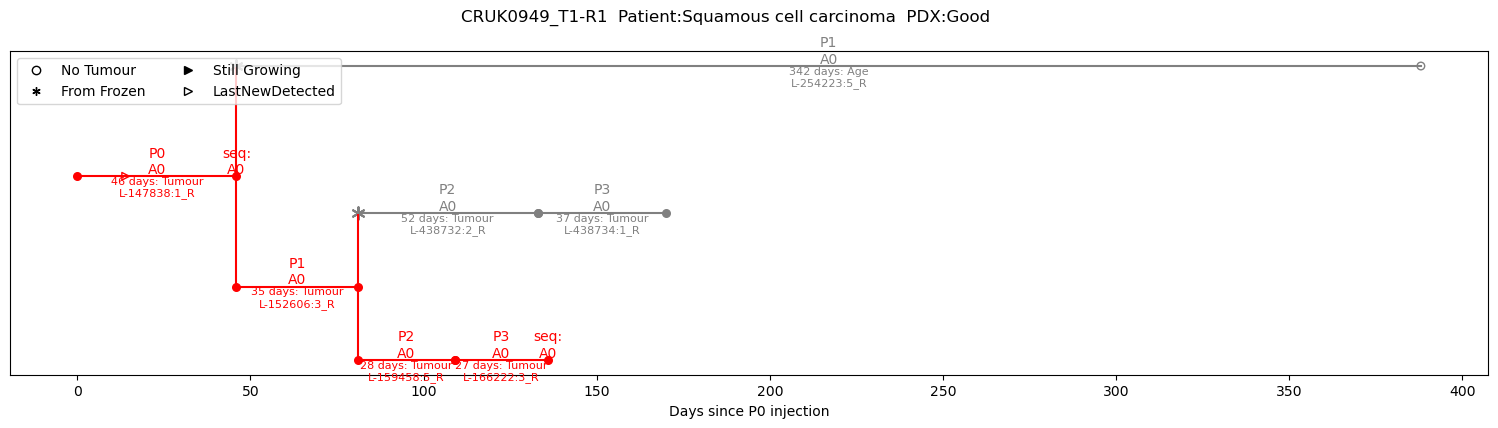

In [11]:
plot_ltx = "CRUK0949"
plot_tumour = "T1"
plot_region = "R1"

tracker_df = load_tracker(False)
patient_data, pdx_data = load_meta()
plot_df = tracker_df[
    (tracker_df["DonorID"] == plot_ltx) & 
    (tracker_df["Region"] == plot_region) &
    (tracker_df["Tumour"] == plot_tumour)
]
#plot_region_df = plot_region_df.sort_values("Passage")
#display(plot_df)
plot_this_df((plot_ltx, plot_tumour, plot_region), plot_df, False)

CRUK0949_T1-R1 - done
CRUK0949_T1-R2 - done
CRUK0949_T1-R3 - done
CRUK0949_T1-R4 - done
CRUK0949_T1-R5 - done
CRUK0949_T1-R6 - done
CRUK0949_T1-R7 - done
CRUK0949_T1-R8 - done


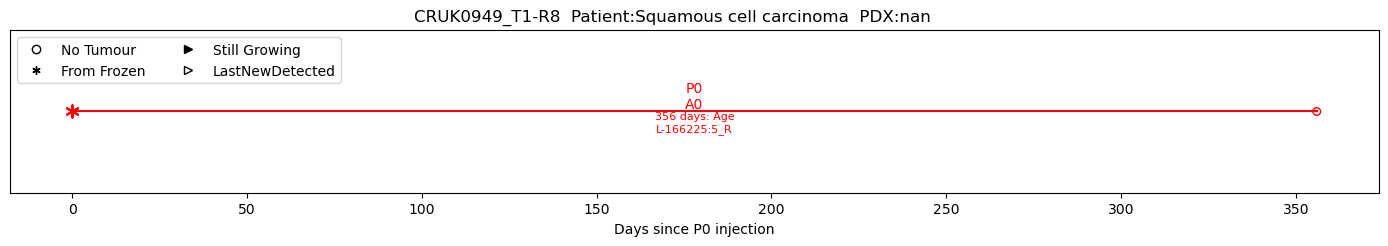

In [12]:
# reload data
tracker_df = load_tracker(True)
patient_data, pdx_data = load_meta()

grouped = tracker_df.groupby(["DonorID","Tumour","Region"])
saveit = True
limit = 255 # used for testing
n = 0
for name, group_df in grouped:
    # skip any P0 only
    #if 1.0 not in group_df.Passage.values and ~group_df.WES_ID.notnull().values.any():
    #    continue
    n+=1
    if n > limit:
        break
    try:
        out_fig = plot_this_df(name, group_df, saveit)
        plt.close(out_fig)
    except Exception as e:
        print(f"{e} with {name}")

# show the last one
out_fig